<a href="https://colab.research.google.com/github/Jax45/Deepfake-Detection/blob/main/Deepfake_Detection_Phase_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5390 Deep Learning UMSL
## sp21 Semester Project
Jackson Hoenig

# Description

1. Watch the lectures in Module 5.
2. With the best model obtained from the previous step, apply various techniques of data augmentation (Image generators) and study the improvement in accuracy
3. Plot your learning curves and include them in your report


#Initial Setup

##Imports

In [ ]:
import requests, zipfile, io, os
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import callbacks
from keras.layers import Dropout
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


##Prevent Google Colab From Stalling

In [ ]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


#Split the Training Data

In [ ]:
print('Downloading and unzipping test file.')
r = requests.get('https://github.com/Jax45/Deepfake-Detection/raw/main/DeepfakeDataset-001.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
#create the directory paths
!mkdir SplitDataset
!mkdir SplitDataset/train
!mkdir SplitDataset/test
!mkdir SplitDataset/valid
!mkdir SplitDataset/train/real
!mkdir SplitDataset/train/fake
!mkdir SplitDataset/test/real
!mkdir SplitDataset/test/fake
!mkdir SplitDataset/valid/real
!mkdir SplitDataset/valid/fake

In [ ]:

#save all real file names to list
import os
count = 0
realFileNames = list()
fakeFileNames = list()
for filename in os.listdir('/content/Real_Images'):
  realFileNames.append(filename)

#save all fake file names to list
for filename in os.listdir('/content/Fake_Images'):
  fakeFileNames.append(filename)



In [ ]:
import random
import os
import imageio
#split real file names into
#train valid and test
random.shuffle(realFileNames)
count = 0
for file in realFileNames:
  if count < len(realFileNames) * 3 / 5: #first 60%
    # print("Train dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/train/real/' + file, imageio.imread('/content/Real_Images/' + file))

  elif count < len(realFileNames) * 4 / 5: #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/real/' + file, imageio.imread('/content/Real_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/real/' + file, imageio.imread('/content/Real_Images/' + file))

  count += 1;


With the fake images we need to make sure the same videos are kept together so they do not get split among the datasets. there are 8 videos so we will take the first 4 videos for training, the next 2 for validation and last 2 for test set.

In [ ]:
count = 0
for file in fakeFileNames:
  if file.startswith('gen1') or file.startswith('gen3') or file.startswith('gen4') or file.startswith('gen5'): #first 60%
    print("Train dataset" + str(count) + file)
    imageio.imwrite('/content/SplitDataset/train/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  elif file.startswith('gen6') or file.startswith('gen7'): #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/fake/' + file, imageio.imread('/content/Fake_Images/' + file))
  
  count += 1;


Train dataset0gen4_frame145.jpg
Train dataset1gen4_frame35.jpg
Train dataset2gen5_frame100.jpg
Train dataset4gen4_frame110.jpg
Train dataset6gen4_frame200.jpg
Train dataset8gen1_frame120.jpg
Train dataset9gen5_frame195.jpg
Train dataset11gen4_frame235.jpg
Train dataset14gen4_frame315.jpg
Train dataset16gen3_frame145.jpg
Train dataset17gen4_frame220.jpg
Train dataset18gen5_frame60.jpg
Train dataset19gen3_frame20.jpg
Train dataset21gen1_frame195.jpg
Train dataset22gen5_frame30.jpg
Train dataset23gen4_frame185.jpg
Train dataset24gen4_frame20.jpg
Train dataset25gen4_frame350.jpg
Train dataset26gen4_frame140.jpg
Train dataset28gen5_frame115.jpg
Train dataset30gen4_frame105.jpg
Train dataset32gen5_frame240.jpg
Train dataset33gen5_frame120.jpg
Train dataset35gen4_frame180.jpg
Train dataset38gen1_frame155.jpg
Train dataset39gen1_frame65.jpg
Train dataset40gen1_frame175.jpg
Train dataset42gen1_frame205.jpg
Train dataset43gen4_frame115.jpg
Train dataset45gen4_frame160.jpg
Train dataset46gen1_fra

In [ ]:
base_dir = 'SplitDataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for s in os.listdir(base_dir):
  for origin in os.listdir(base_dir+'/'+s):
    print(base_dir+'/'+s+'/'+origin+': '+str(len(os.listdir(base_dir+'/'+s+'/'+origin))))
  print('-----')

SplitDataset/valid/real: 101
SplitDataset/valid/fake: 73
-----
SplitDataset/train/real: 302
SplitDataset/train/fake: 215
-----
SplitDataset/test/real: 100
SplitDataset/test/fake: 73
-----


## Create Data Generators

In [ ]:
#get a validation set generator
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    brightness_range=[0.8,1.2],
    fill_mode='nearest' 
    )

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
class_dictionary = train_generator.class_indices
print(class_dictionary)

Found 517 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [ ]:
#get a validation set generator
validate_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validate_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

Found 174 images belonging to 2 classes.


In [ ]:
#get a test set generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical')

Found 173 images belonging to 2 classes.


#Take the best model from Phase 3.

In [ ]:
#Make sure the Earlystop callback is used with the validation set
callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
originalModel = Sequential()
originalModel.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
originalModel.add( MaxPool2D(4, 4) )
originalModel.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
originalModel.add( Flatten() )
originalModel.add( Dense( 8, activation = 'sigmoid' ) )
originalModel.add( Dense( 2, activation = 'sigmoid' ) )
originalModel.summary()
originalModel.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
originalHistory = originalModel.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 59536)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 476296    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
__________________________________________________

# Data Augmentation

In [ ]:
#Adding a rotation range of 40 degrees
train_datagen1 = ImageDataGenerator(rescale=1./255,
    rotation_range=40
    )

train_generator1 = train_datagen1.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

#adding a width_shift_range of 0.2
train_datagen2 = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.2
    )

train_generator2 = train_datagen2.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding a height shift range of 0.2
train_datagen3 = ImageDataGenerator(rescale=1./255,
    height_shift_range=0.2
    )

train_generator3 = train_datagen3.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding a shear range of 0.2
train_datagen4 = ImageDataGenerator(rescale=1./255,
    shear_range=0.2
    )

train_generator4 = train_datagen4.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding a zoom_range of 0.2
train_datagen5 = ImageDataGenerator(rescale=1./255,
    zoom_range=0.2
    )

train_generator5 = train_datagen5.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding a horizontal flip=true
train_datagen6 = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True
    )

train_generator6 = train_datagen6.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
#adding fill_mode='nearest'
train_datagen7 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest'
    )

train_generator7 = train_datagen7.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

#adding fill_mode='nearest' and     height_shift_range=0.2

train_datagen8 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    height_shift_range=0.2
    )

train_generator8 = train_datagen8.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
   



#adding the previous augmentations from the original generator.
train_datagen9 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    height_shift_range=0.2
    )

train_generator9 = train_datagen9.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

train_datagen10 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    brightness_range=[0.8,1.2],
    height_shift_range=0.2
    )

train_generator10 = train_datagen10.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

#best combined?
train_datagen11 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    height_shift_range=0.2,
    width_shift_range=0.2
    )

train_generator11 = train_datagen11.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

#all
train_datagen12 = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
    )

train_generator12 = train_datagen12.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')


Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 517 images belonging to 2 classes.


## Run for all the models

In [ ]:
model1 = Sequential()
model1.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model1.add( MaxPool2D(4, 4) )
model1.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model1.add( Flatten() )
model1.add( Dense( 8, activation = 'sigmoid' ) )
model1.add( Dense( 2, activation = 'sigmoid' ) )
model1.summary()
model1.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history1 = model1.fit(  train_generator1, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 476296    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model2 = Sequential()
model2.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model2.add( MaxPool2D(4, 4) )
model2.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model2.add( Flatten() )
model2.add( Dense( 8, activation = 'sigmoid' ) )
model2.add( Dense( 2, activation = 'sigmoid' ) )
model2.summary()
model2.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history2 = model2.fit(  train_generator2, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_2 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 476296    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model3 = Sequential()
model3.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model3.add( MaxPool2D(4, 4) )
model3.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model3.add( Flatten() )
model3.add( Dense( 8, activation = 'sigmoid' ) )
model3.add( Dense( 2, activation = 'sigmoid' ) )
model3.summary()
model3.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history3 = model3.fit(  train_generator3, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_3 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 476296    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model4 = Sequential()
model4.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model4.add( MaxPool2D(4, 4) )
model4.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model4.add( Flatten() )
model4.add( Dense( 8, activation = 'sigmoid' ) )
model4.add( Dense( 2, activation = 'sigmoid' ) )
model4.summary()
model4.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history4 = model4.fit(  train_generator4, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_4 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 476296    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model5 = Sequential()
model5.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model5.add( MaxPool2D(4, 4) )
model5.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model5.add( Flatten() )
model5.add( Dense( 8, activation = 'sigmoid' ) )
model5.add( Dense( 2, activation = 'sigmoid' ) )
model5.summary()
model5.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history5 = model5.fit(  train_generator5, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_5 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 476296    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model6 = Sequential()
model6.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model6.add( MaxPool2D(4, 4) )
model6.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model6.add( Flatten() )
model6.add( Dense( 8, activation = 'sigmoid' ) )
model6.add( Dense( 2, activation = 'sigmoid' ) )
model6.summary()
model6.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history6 = model6.fit(  train_generator6, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_6 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 476296    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model7 = Sequential()
model7.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model7.add( MaxPool2D(4, 4) )
model7.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model7.add( Flatten() )
model7.add( Dense( 8, activation = 'sigmoid' ) )
model7.add( Dense( 2, activation = 'sigmoid' ) )
model7.summary()
model7.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history7 = model7.fit(  train_generator4, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_7 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 476296    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model8 = Sequential()
model8.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model8.add( MaxPool2D(4, 4) )
model8.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model8.add( Flatten() )
model8.add( Dense( 8, activation = 'sigmoid' ) )
model8.add( Dense( 2, activation = 'sigmoid' ) )
model8.summary()
model8.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history8 = model8.fit(  train_generator8, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_8 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 476296    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model9 = Sequential()
model9.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model9.add( MaxPool2D(4, 4) )
model9.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model9.add( Flatten() )
model9.add( Dense( 8, activation = 'sigmoid' ) )
model9.add( Dense( 2, activation = 'sigmoid' ) )
model9.summary()
model9.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history9 = model9.fit(  train_generator9, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_9 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 476296    
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model10 = Sequential()
model10.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model10.add( MaxPool2D(4, 4) )
model10.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model10.add( Flatten() )
model10.add( Dense( 8, activation = 'sigmoid' ) )
model10.add( Dense( 2, activation = 'sigmoid' ) )
model10.summary()
model10.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history10 = model10.fit(  train_generator10, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_10 (Flatten)         (None, 59536)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 476296    
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
_______________________________________________

In [ ]:
model11 = Sequential()
model11.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model11.add( MaxPool2D(4, 4) )
model11.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model11.add( Flatten() )
model11.add( Dense( 8, activation = 'sigmoid' ) )
model11.add( Dense( 2, activation = 'sigmoid' ) )
model11.summary()
model11.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history11 = model11.fit(  train_generator11, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 476296    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [ ]:
model12 = Sequential()
model12.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model12.add( MaxPool2D(4, 4) )
model12.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model12.add( Flatten() )
model12.add( Dense( 8, activation = 'sigmoid' ) )
model12.add( Dense( 2, activation = 'sigmoid' ) )
model12.summary()
model12.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history12 = model12.fit(  train_generator12, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_2 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 476296    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

#Evaluate on the test set

In [ ]:
testing_loss, testing_acc =originalModel.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Previous Phase Augmentation")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model1.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 1")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model2.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 2")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model3.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 3")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model4.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 4")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model5.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 5")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model6.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 6")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model7.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 7")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model8.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 8")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model9.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 9")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model10.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 10")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model11.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)

print("Model 11")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model12.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 12")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")

___________________________________
Previous Phase Augmentation
testing_acc: 0.5780346989631653
testing_loss: 0.6809622049331665
___________________________________
Model 1
testing_acc: 0.5780346989631653
testing_loss: 0.6810881495475769
___________________________________
Model 2
testing_acc: 0.5780346989631653
testing_loss: 0.6809688210487366
___________________________________
Model 3
testing_acc: 0.5780346989631653
testing_loss: 0.6810293197631836
___________________________________
Model 4
testing_acc: 0.5780346989631653
testing_loss: 0.68097984790802
___________________________________
Model 5
testing_acc: 0.5780346989631653
testing_loss: 0.6809921264648438
___________________________________
Model 6
testing_acc: 0.5780346989631653
testing_loss: 0.6810362935066223
___________________________________
Model 7
testing_acc: 0.5780346989631653
testing_loss: 0.680928111076355
___________________________________
Model 8
testing_acc: 0.5780346989631653
testing_loss: 0.6811380386352539
__

#Plot the curves

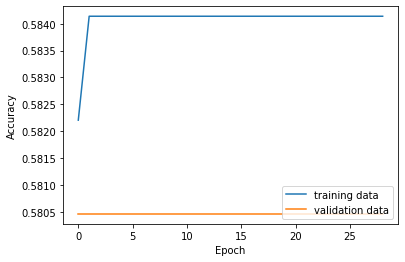

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(originalHistory.history['accuracy'])
plt.plot(originalHistory.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("original plot.png")

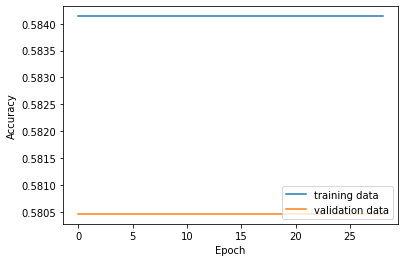

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot1.png")

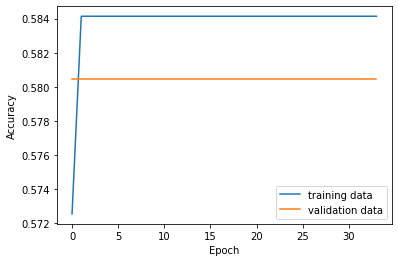

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot2.png")

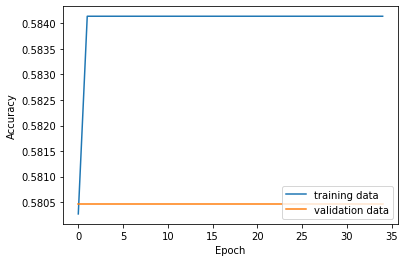

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot3.png")

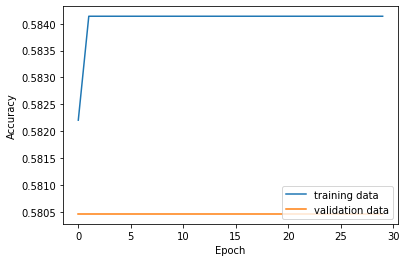

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot4.png")

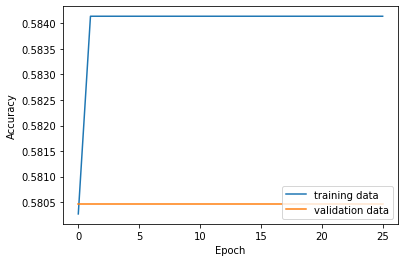

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot5.png")

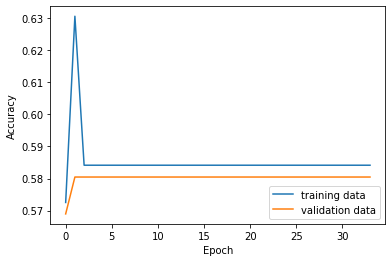

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot6.png")

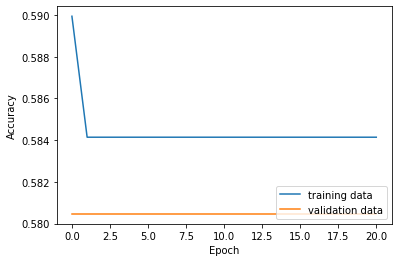

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot7.png")

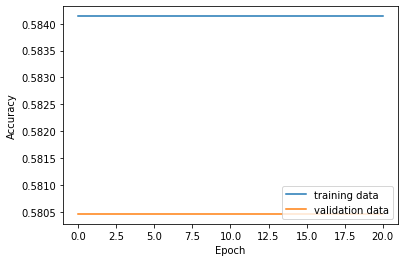

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot8.png")

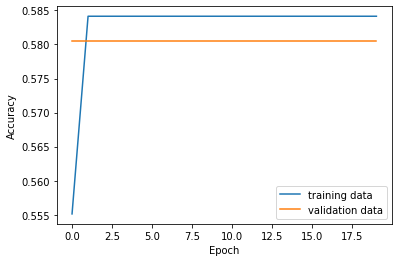

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history9.history['accuracy'])
plt.plot(history9.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot9.png")

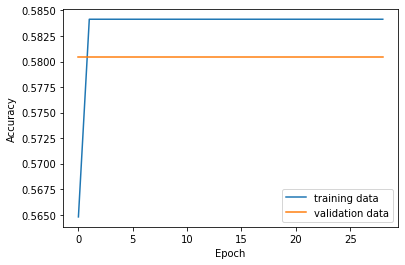

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot10.png")

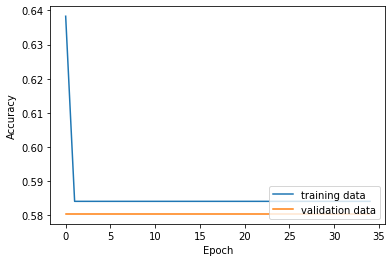

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history11.history['accuracy'])
plt.plot(history11.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot11.png")

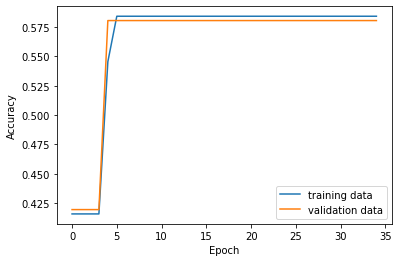

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history12.history['accuracy'])
plt.plot(history12.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot12.png")